In [1]:
import casadi as ca
import casadi.tools as cat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import networkx as nx
import sys
import seaborn as sns
import datetime
sys.path.insert(0, './ocp-solving')
from COVIDVaccinationOCP import COVIDVaccinationOCP#, rk4_mob, rhs_py_total, rk4, rhs_py_total_mob
from ItalySetup import ItalySetup
from scipy.integrate import solve_ivp
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd('geography-paper-master/',nargout=0)
eng.run('single_build.m', nargout=0)

parameters = np.array(eng.eval('PAR'))

s = ItalySetup(10)

ocp_params = {'N': 52,
              'T': 52*7,               # N * 7
              'n_int_steps': 10,
               'scaling':  1
             }
scaling = ocp_params['scaling']
N = ocp_params['N']
T = ocp_params['T']
n_int_steps = ocp_params['n_int_steps']

Loaded Italy Setup with 10 nodes.


In [2]:
model_days = pd.date_range(s.start_date, s.end_date, freq='1D')
model_step = pd.date_range(s.start_date, s.end_date, freq='W-MON')
N = len(model_step)
T = len(model_days)

In [11]:
mobintime = s.mobility_ts.resample('W-MON').mean()

In [16]:
# New code
x0 = np.zeros(8*s.nnodes)
nx = 8

states = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R']

S, E, P, I, A, Q, H, R = np.arange(nx)
for i in range(s.nnodes):
    x0[i*nx:(i+1)*nx] = [s.ic['S'][i], 
                         s.ic['E'][i],
                         s.ic['P'][i],
                         s.ic['I'][i], 
                         s.ic['A'][i],
                         s.ic['Q'][i],
                         s.ic['H'][i], 
                         s.ic['R'][i]]

dt = T/N/n_int_steps

integ_rk4 =  np.array([x0]).T
integ_rk4_mob =  np.array([x0]).T
integ_nomob = np.array([x0]).T
integ_withmob =  np.array([x0]).T

In [59]:
deltaE = eng.eval('deltaE')
deltaP = eng.eval('deltaP')
sigma = eng.eval('sigma')
eta = eng.eval('eta')
gammaI = eng.eval('gammaI')
gammaA = eng.eval('gammaA')
gammaQ = eng.eval('gammaQ')
gammaH = eng.eval('gammaH')
alphaI = eng.eval('alphaI')
alphaH = eng.eval('alphaH')
zeta = eng.eval('V.zeta')
eta = eng.eval('eta')
r = eng.eval('r')
p = np.array(eng.eval('V.p'))[:10]
q = np.array(eng.eval('full(V.q)'))[:10,:10]
betaP0 = eng.eval('betaP0')
epsilonA = eng.eval('epsilonI')
epsilonI = eng.eval('epsilonA')

In [38]:
tmob = [matlab2datetime(int(t)) for t in tmob]

In [48]:
beta_ratio = np.array(eng.eval('beta_ratio'))[:10]
beta_ratio_ts = pd.DataFrame(beta_ratio.T, index = model_days, columns=np.arange(s.nnodes))
betaratiointime = beta_ratio_ts.resample('W-MON').mean()

SyntaxError: invalid syntax (<ipython-input-223-73517138b3ff>, line 1)

In [215]:
def rhs_py(t, x, u, cov, p, mob, pop_node):
        S, E, P, I, A, Q, H, R = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]
        
        # Compute mobility matrix C (see model equations). According to the
        # assumptions used in the preprint: C_S=C_E=C_P=C_A=C_R. Moreover,
        # C_I is an idenity matrix (no extra node mobility for the I class)
        #C = (r*V.p.*mob_ratio(:,i_t)).*V.q; %compute off diagonal elements
        #C(1:n+1:end) = 1-(sum(C,2)-diag(C));%set diagonal imposing row-stocasticity
        
        # Force of infection lambda (this formulation is a numerically faster simplification of
        # the equation reported in the preprint text valid under the
        # assumptions listed above for the computation of C

        #foi= C *((C'*(betaP0*beta_ratio(:,i_t).*(P+epsilonA*A))+epsilonI*betaP0*beta_ratio(:,i_t).*I)./(C'*(S+E+P+R+A)+I));
        foi = mob
        rhs = [None] * 8
        rhs[0] = -foi*S;
        rhs[1] = foi*S-deltaE*E;
        rhs[2] = deltaE*E-deltaP*P;
        rhs[3] = sigma*deltaP*P-(eta+gammaI+alphaI)*I;
        rhs[4] = (1-sigma)*deltaP*P-gammaA*A;
        rhs[5] = zeta*eta*I-gammaQ*Q;
        rhs[6] = (1-zeta)*eta*I-(gammaH+alphaH)*H;
        rhs[7] = gammaI*I+gammaA*A+gammaH*H+gammaQ*Q;
        rhs_ell = [None] * 3
        rhs_ell[0] = gammaH*H;                            # recovered from the hospital
        rhs_ell[1] = alphaH*H;                            # total death
        rhs_ell[2] = (1-zeta)*eta*I;                   # cumulative hospitalized cases
        
        return rhs, rhs_ell

def rhs_py_total(t, x, u, covar, p, M, c, pop_node):
    """ 
        Give the complete rhs of the equation, plugin-in the mobility as it is usually implemented. 
        I think it works well
    """
    nx = 8
    nu = 1
    nc = 1
    X = np.zeros((M,nx))
    U = []
    #C = []
    for i in range(M):  # Uses flat vectors
        #X.append(x[i * nx:(i + 1) * nx])
        
        X[i,:]= x[i * nx:(i + 1) * nx]
        U.append(u[i * nu:(i + 1) * nu])
        #C.append(covar[i * nc:(i + 1) * nc])
    rhs = np.array([])
    for i in range(M):
        foi=C@((C.T@(betaP0*betaR*(X[:,P]+epsilonA*X[:,A]))+epsilonI*betaP0*betaR*X[:,I])/ \
         (C.T@(X[:,S]+X[:,E]+X[:,P]+X[:,R]+X[:,A])+X[:,I]))
        rhs = np.append(rhs, rhs_py(t, X[i], U[i], C[i], p, foi[i], pop_node[i])[0])
    return rhs


def rhs_py_total_mob(t, x, u, covar, p, M, c, mob, pop_node):
    """ 
        Same as rhs_py_total, however the mobility as to be provided as an array. It allows to better 
        reproduce what the ocp is doing. Works well.
    """
    nx = 8
    nu = 1
    nc = 1
    X = []
    U = []
    C = []
    for i in range(M):  # Uses flat vectors
        X.append(x[i * nx:(i + 1) * nx])
        U.append(u[i * nu:(i + 1) * nu])
        C.append(covar[i * nc:(i + 1) * nc])

    rhs = np.array([])
    for i in range(M):
        rhs = np.append(rhs, rhs_py(t, X[i], U[i], C[i], p, mob[i], pop_node[i])[0])
    return rhs


def rk4_step(dt, states, controls, covar, params, M, c, pop_node):
    """ A step of RK4 with the right mobility, should work well"""
    k1 = rhs_py_total(0, states, controls, covar, params, M, c, pop_node)
    k2 = rhs_py_total(0, states + dt / 2 * k1, controls, covar, params, M, c, pop_node)
    k3 = rhs_py_total(0, states + dt / 2 * k2, controls, covar, params, M, c, pop_node)
    k4 = rhs_py_total(0, states + dt * k3, controls, covar, params, M, c, pop_node)

    return states + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)


def rk4_step_mob(dt, states, controls, covar, params, M, c, mob, pop_node):
    """ A step of RK4 with the mobility provided, should work well"""

    k1 = rhs_py_total_mob(0, states, controls, covar, params, M, c, mob, pop_node)

    k2 = rhs_py_total_mob(0, states + dt / 2 * k1, controls, covar, params, M, c, mob, pop_node)
    k3 = rhs_py_total_mob(0, states + dt / 2 * k2, controls, covar, params, M, c, mob, pop_node)
    k4 = rhs_py_total_mob(0, states + dt * k3, controls, covar, params, M, c, mob, pop_node)

    return states + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)


def rk4(dt, states, controls, covar, params, M, c, n_int_steps, pop_node):
    x_ = states
    for k in range(n_int_steps):
        x_ = rk4_step(dt, x_, controls, covar, params, M, c, pop_node)

    return x_


def rk4_mob(dt, states, controls, covar, params, M, c, n_int_steps, mob, pop_node):
    x_ = states
    for k in range(n_int_steps):  # Shouldn't mob be calculated here ? no because it's for 1 integ interval
        x_ = rk4_step_mob(dt, x_, controls, covar, params, M, c, mob, pop_node)

    return x_

In [224]:
p

array([[0.50478606],
       [0.48130168],
       [0.51892855],
       [0.52319152],
       [0.48981721],
       [0.47078733],
       [0.52665489],
       [0.42648553],
       [0.45363807],
       [0.48066564]])

In [243]:
C = r*p.flatten()*mobK*q

In [249]:
C

array([[9.97879761e-01, 3.31183137e-04, 1.00616473e-04, 9.47109052e-04,
        3.88413883e-04, 9.87507883e-05, 2.25000139e-04, 3.10096669e-06,
        8.69576120e-06, 1.73686389e-05],
       [6.86684960e-03, 9.83075637e-01, 7.30906730e-03, 6.29707279e-05,
        1.58168823e-04, 2.42961686e-03, 7.11177666e-05, 0.00000000e+00,
        3.99507473e-06, 2.25765315e-05],
       [5.11574226e-04, 2.74396683e-03, 9.96429099e-01, 1.03425333e-05,
        1.13611338e-04, 1.63175699e-04, 6.24659857e-06, 3.93438913e-06,
        5.38055373e-06, 1.26691665e-05],
       [5.33517864e-03, 7.05978573e-06, 1.18404234e-05, 9.93382652e-01,
        7.75946792e-04, 8.40176483e-05, 4.29168424e-06, 4.03147466e-05,
        3.10520604e-04, 4.81781182e-05],
       [1.07900145e-02, 1.40003866e-04, 5.35625451e-05, 5.66904142e-03,
        9.79016606e-01, 4.12271889e-03, 1.72963763e-05, 7.00330938e-06,
        5.74651075e-05, 1.26287996e-04],
       [1.27492774e-03, 8.00438568e-04, 2.15431173e-04, 1.46317993e-04,
   

In [242]:
C (old)

array([[9.97887582e-01, 3.47342711e-04, 9.78743471e-05, 9.13790496e-04,
        4.00283836e-04, 1.05882248e-04, 2.15657226e-04, 3.67028802e-06,
        9.67621386e-06, 1.82402192e-05],
       [6.54738020e-03, 9.83884459e-01, 6.77909586e-03, 5.79289142e-05,
        1.55419038e-04, 2.48387881e-03, 6.49934159e-05, 0.00000000e+00,
        4.23870104e-06, 2.26064055e-05],
       [5.25906899e-04, 2.95848276e-03, 9.96174352e-01, 1.02582620e-05,
        1.20363608e-04, 1.79861527e-04, 6.15495720e-06, 4.78718894e-06,
        6.15495720e-06, 1.36776827e-05],
       [5.52970950e-03, 7.67423062e-06, 1.19376921e-05, 9.93064201e-01,
        8.28816907e-04, 9.33698058e-05, 4.26346145e-06, 4.94561529e-05,
        3.58130762e-04, 5.24405759e-05],
       [1.04700491e-02, 1.42480914e-04, 5.05577438e-05, 5.30741406e-03,
        9.79525263e-01, 4.28936495e-03, 1.60865549e-05, 8.04327743e-06,
        6.20481402e-05, 1.28692439e-04],
       [1.18905786e-03, 7.82952468e-04, 1.95445534e-04, 1.31662411e-04,
   

In [246]:
C.diagonal()


AttributeError: 'numpy.ndarray' object has no attribute 'diag'

In [ ]:
C

In [250]:
for k in range(N):
    print(k, end = ':')
    #covk = np.squeeze(ca.veccat(*ocp.arg['p']['cov',:,k]))
    mobK = mobintime.to_numpy().T[:,k]
    betaR = betaratiointime.to_numpy().T[:,k]
    C = r*p.flatten()*mobK*q
    np.fill_diagonal(C,1-C.sum(axis=1)+ C.diagonal())
    foi=C@((C.T@(betaP0*betaR*(integ_withmob[P::nx,-1]+epsilonA*integ_withmob[A::nx,-1]))+epsilonI*betaP0*betaR*integ_withmob[I::nx,-1])/ \
           (C.T@(integ_withmob[S::nx,-1]+integ_withmob[E::nx,-1]+integ_withmob[P::nx,-1]+integ_withmob[R::nx,-1]+integ_withmob[A::nx,-1])+integ_withmob[I::nx,-1]));
    uk = np.zeros(s.nnodes).T         # no contro3l
    #uk = 15000* scaling * np.ones(10).T        # somehow makes the integration very difficult
    pnum = 0
    x_ = rk4(      dt, integ_rk4[:,-1],    uk, covk, pnum, s.nnodes, s.mobility ,n_int_steps,      s.pop_node)
    sol_ = rk4_mob(dt, integ_rk4_mob[:,-1],uk, covk, pnum, s.nnodes, s.mobility, n_int_steps, foi, s.pop_node)
    
    sol0 = solve_ivp(lambda t, y: rhs_py_total(t, y, uk, covk, pnum, s.nnodes, s.mobility, s.pop_node),
                     [0,T/N], integ_nomob[:,-1])#, rtol=1e-8, atol=1e-8)
    sol1 = solve_ivp(lambda t, y: rhs_py_total_mob(t, y, uk, covk, pnum, s.nnodes, s.mobility, foi, s.pop_node*scaling),
                     [0,T/N], integ_withmob[:,-1])#, rtol=1e-8, atol=1e-8)
    
    integ_nomob  =  np.append(integ_nomob,   np.array([sol0['y'][:,-1]]).T, axis=1)
    integ_withmob = np.append(integ_withmob, np.array([sol1['y'][:,-1]]).T, axis=1)
    integ_rk4 =     np.append(integ_rk4,     np.array([x_]).T,              axis=1)
    integ_rk4_mob = np.append(integ_rk4_mob, np.array([sol_]).T,            axis=1)

0:1:2:3:4:5:6:7:8:9:10:11:12:13:14:15:16:17:18:19:20:21:22:23:

In [143]:
P

2

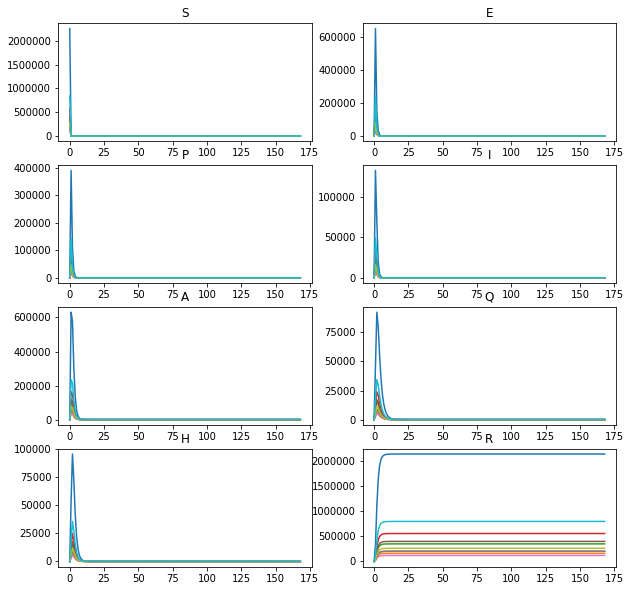

In [217]:
fig, axes = plt.subplots(nx//2,2, figsize = (10,10))
integ_to_plot = integ_rk4_mob

for i in range(s.nnodes):
    for si, st in enumerate(states):
        axes.flat[si].plot(integ_to_plot[i*nx+si,:].T)
        axes.flat[si].set_title(st);


#axes.flat[0].legend(np.arange(s.nnodes));

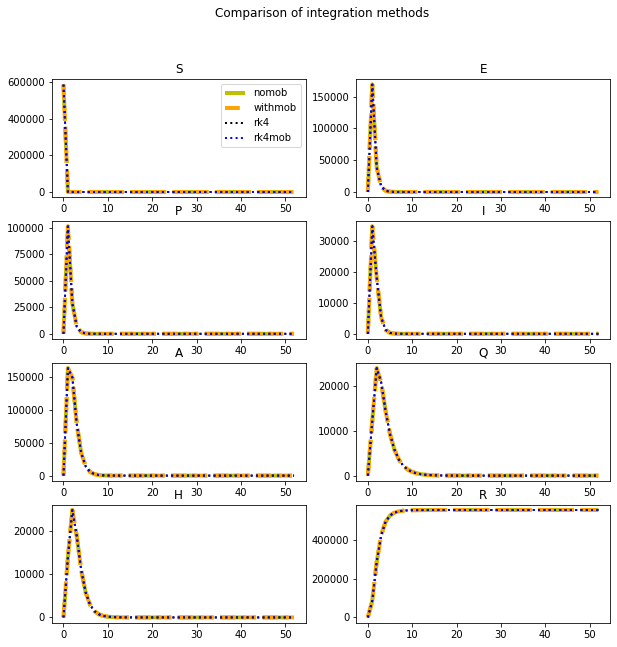

In [218]:
fig, axes = plt.subplots(nx//2,2, figsize = (10,10))

node = 3
til = 53  # 53 for full matrix

for si, st in enumerate(states):

    axes.flat[si].plot(integ_nomob[node*nx+si,:til].T,   linestyle='-.', lw = 4, color='y')
    
    axes.flat[si].plot(integ_withmob[node*nx+si,:til].T, linestyle='--', lw = 4, color='orange')
    axes.flat[si].plot(integ_rk4[node*nx+si,:til].T, linestyle=':', lw = 2, color='k')
    axes.flat[si].plot(integ_rk4_mob[node*nx+si,:til].T, linestyle=':', lw = 2, color='b')
    axes.flat[si].set_title(st)


fig.suptitle("Comparison of integration methods")
axes.flat[0].legend(['nomob', 'withmob', 'rk4', 'rk4mob'])